# System preparation

## Import libraries

In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Data 
import numpy as np
import pandas as pd

#Regular expressions
import re as re

# Utilities
from time import time

from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Classification
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score , roc_auc_score

from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


# Classification algorithms
import lightgbm as lgb
import xgboost as xgb

from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier


# Others
import warnings
from functools import reduce
from pathlib import Path
import os


In [2]:
# Configurations.
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

# Data preparation

### Load data



Read the csv with the feature engineering applied before to the raw data.

In [3]:
compressors_all_data = pd.read_csv("../data/compressors_all_data_best_features_2days.csv", error_bad_lines=False, index_col=0)

In [6]:
#Make sure the datetime format is correct
compressors_all_data["datetime"] = pd.to_datetime(compressors_all_data["datetime"], format="%Y-%m-%d %H:%M:%S")

In [7]:
compressors_all_data.head()

,compressorID,datetime,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,...,s-8760,c-8760,comp1_fail,comp2_fail,comp3_fail,comp4_fail,rul_comp1,rul_comp2,rul_comp3,rul_comp4
0,1,2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502,NaN,NaN,NaN,...,0.000000,1.000000,0.0,0.0,0.0,0.0,63.875,108.875,NaN,3.875
1,1,2015-01-01 12:00:00,2,164.192565,403.949857,105.687417,34.255891,NaN,NaN,NaN,...,0.002152,0.999998,0.0,0.0,0.0,0.0,63.750,108.750,NaN,3.750
2,1,2015-01-01 15:00:00,3,168.134445,435.781707,107.793709,41.239405,NaN,NaN,NaN,...,0.004304,0.999991,0.0,0.0,0.0,0.0,63.625,108.625,NaN,3.625
3,1,2015-01-01 18:00:00,4,165.514453,430.472823,101.703289,40.373739,NaN,NaN,NaN,...,0.006455,0.999979,0.0,0.0,0.0,0.0,63.500,108.500,NaN,3.500
4,1,2015-01-01 21:00:00,5,168.809347,437.111120,90.911060,41.738542,NaN,NaN,NaN,...,0.008607,0.999963,0.0,0.0,0.0,0.0,63.375,108.375,NaN,3.375


Create lists with the names of the columns for different data:
- Sensors: telemetry information
- Errors: compressor errors and counts
- Maintenance: time since last maintenance
- Model
- Compressor information: Age
- Failures: failures in the different components

## Feature selection

Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

In [8]:
cols_failures_dum = [col for col in compressors_all_data.columns if 'fail' in col]
cols_rul = [col for col in compressors_all_data.columns if 'rul' in col]

In [9]:
predictors = list(compressors_all_data.columns)
predictors = [ele for ele in predictors if ele not in (cols_rul + cols_failures_dum + ['datetime']) ]

In [10]:
target = cols_failures_dum 

In [11]:
X = compressors_all_data[(predictors+target)+ ['datetime']].dropna()
y = compressors_all_data[(predictors+target)+ ['datetime']].dropna()

In [12]:
X = X[predictors+ ['datetime']]
y= y[target+ ['datetime']]

## Model split: Training, Validation and Testing

When working with time series as in this thesis, partitioning in training, validation, and testing must be done carefully to avoid overestimating the performance of the models. 

Predictive models do not have advanced knowledge of future time trends - in practice, such trends are likely to exist and have an adverse impact on model performance. To get an accurate assessment of the performance of a predictive model, it is recommended to perform training on older records and validation / testing using the newer records.

For both reasons, a time-dependent splitting strategy is an excellent choice for predictive maintenance models. The division is done by choosing a point in time according to the desired size of the training and test sets: all the records before the time point are used to train the model, and all the remaining records are used for testing.

In [13]:
# We establish the times corresponding to the records that will be used for training and tests.
threshold_dates = [
    pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")
]

In [14]:
# We make the partition of separate dates.
last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [15]:
# Typically 20-30% of the data is used.
X_train = X.loc[X["datetime"] < last_train_date]
y_train = y.loc[y["datetime"] < last_train_date]

X_test = X.loc[X["datetime"] > first_test_date]
y_test = y.loc[y["datetime"] > first_test_date]

print(f"{X_train.shape[0]} registers for trainning")
print(f"{X_test.shape[0]} registers for testing")
print(f"{X_test.shape[0] / X_train.shape[0] * 100:0.1f}% of the total data is used for testing")

216700 registers for trainning
73900 registers for testing
34.1% of the total data is used for testing


Check how many failures we have in the train and test

In [16]:
fails_train = y_train[y_train["comp1_fail"] != 0].shape[0]
no_fails_train = y_train[y_train["comp1_fail"] == 0].shape[0]
fails_test = y_test[y_test["comp1_fail"] != 0].shape[0]
no_fails_test = y_test[y_test["comp1_fail"] == 0].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f}% of the total cases are failures in the train dataset")
print(f"{fails_test / no_fails_test * 100:0.1f}% of the total cases are failures in the test dataset")

1.1% of the total cases are failures in the train dataset
0.9% of the total cases are failures in the test dataset


We see it's crearly an unbalanced problem. For class unbalance problems Get more data. Minor sample of the majority class. SMOTE (Synthetic Minority Over-sampling Technique). Assign weights to minority class.

## Drop Datetime

In [17]:
X.drop('datetime', axis=1,inplace=True)
y.drop('datetime', axis=1,inplace=True)

X_train.drop('datetime',axis=1,inplace=True)
y_train.drop('datetime',axis=1,inplace=True)

X_test.drop('datetime',axis=1,inplace=True)
y_test.drop('datetime',axis=1,inplace=True)

# Results in test set

Create a dataframe with the test values and create new column with the predictions coming from the model.

## Load Dataframes

In [27]:
# Load model
lgb_model_comp1_fail=lgb.Booster(model_file="models/lgb_model_comp1_fail.model")
lgb_model_comp2_fail=lgb.Booster(model_file="models/lgb_model_comp2_fail.model")
lgb_model_comp3_fail=lgb.Booster(model_file="models/lgb_model_comp3_fail.model")
lgb_model_comp4_fail=lgb.Booster(model_file="models/lgb_model_comp4_fail.model")

# XGB
xgb_model_comp1_fail = xgb.Booster()
xgb_model_comp1_fail.load_model("models/xgb_model_comp1_fail.model")
xgb_model_comp2_fail = xgb.Booster()
xgb_model_comp2_fail.load_model("models/xgb_model_comp2_fail.model")
xgb_model_comp3_fail = xgb.Booster()
xgb_model_comp3_fail.load_model("models/xgb_model_comp3_fail.model")
xgb_model_comp4_fail = xgb.Booster()
xgb_model_comp4_fail.load_model("models/xgb_model_comp4_fail.model")

In [20]:
test_result = pd.DataFrame(compressors_all_data.loc[compressors_all_data["datetime"] > first_test_date])

# SHAP

We are still not aware of the importance that the featuring variables we created will have in our classification model. For that reason, we will make a first exploration and see the features that will affect more our model in classifying our compressor in HEALTH or POTENTIALLY FAULTY

### SHAP visualizations

In [ ]:
!#pip install shap

     |████████████████████████████████| 356 kB 5.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491641 sha256=839178ef81ff2879bd11aa373392c7447760f825490305096ab171075e77f8dc
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [22]:
import shap
shap.initjs()

**Variables influencing the failure**

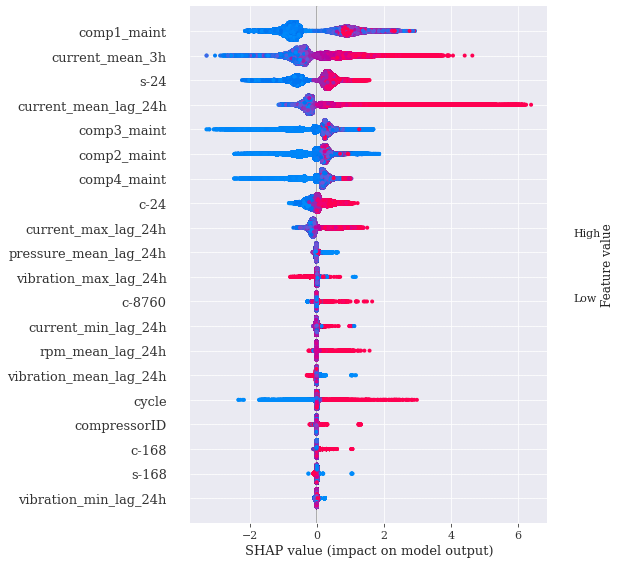

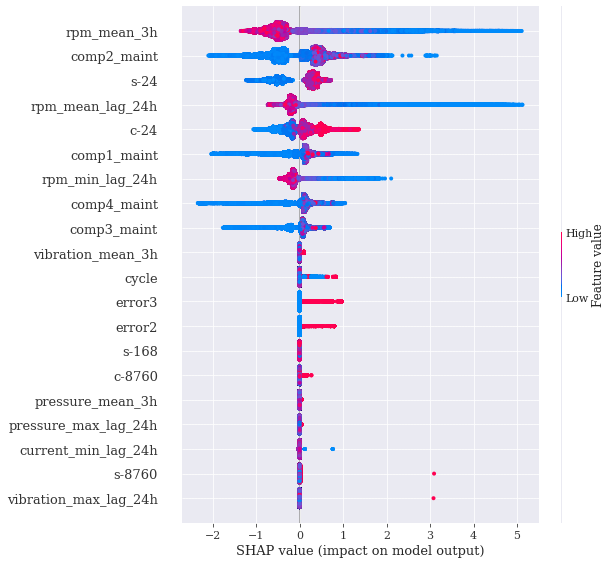

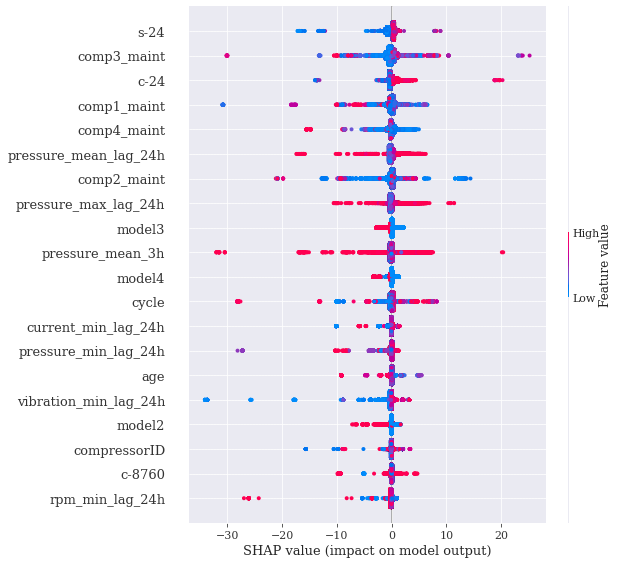

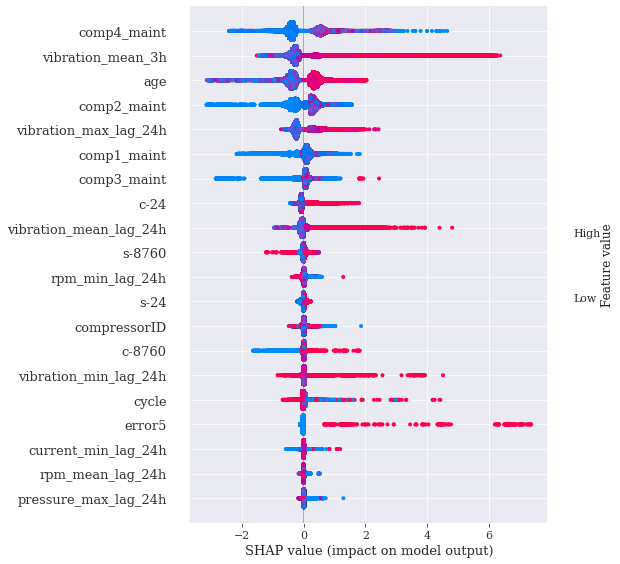

In [57]:
for rul_comp in y.columns:
    
    exec('lgb_temp = lgb_model_{}'.format(rul_comp))
    lgb_temp.params['objective'] = 'binary'
    explainer = shap.TreeExplainer(lgb_temp)
    shap_values = explainer.shap_values(X)
    fig = shap.summary_plot(shap_values[1], X, show= False)
    #plt.savefig(f"shap_lgb_model_{rul_comp}.png", bbox_inches='tight')
    plt.show()


**Individual cases**

In [37]:
X_test_copy = X_test.copy()

In [38]:
X_test_copy['prev_index'] = X_test_copy.index

In [39]:
X_test_copy.reset_index(drop=True,inplace=True)

Input the number from the data of the csv

In [40]:
X_test_copy[X_test_copy['prev_index']== 81746].index[0]

20650

In [41]:
X_test_copy.drop('prev_index', axis= 1, inplace=True)

In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][20650,:],X_test_copy.loc[20650,:],link='logit')

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][111,:],X_test_copy.loc[111,:],link='logit')

### Kernel explainer

Here is an example using KernelExplainer to get similar results. The results aren't identical because KernelExplainer gives an approximate result. But the results tell the same story.

In [45]:
pd_shap = pd.DataFrame(lgb_model_comp1_fail.predict(X_test,pred_contrib=True),
                       columns = list(X_test.columns)+['other'] ).drop(['other'],axis=1)

In [46]:
pd_shap.iloc[1,:].sort_values(axis=0 , ascending = False).index[-3:]

Index(['s-24', 'current_mean_3h', 'comp1_maint'], dtype='object')

In [47]:
pd_contrib = pd.DataFrame({'contrib1_max1' : ['0'] , 'contrib1_max2' : ['0'], 'contrib1_max3' : ['0'],
                          'contrib0_max1' : ['0'] , 'contrib0_max2' : ['0'], 'contrib0_max3' : ['0']})

for i in range (pd_shap.shape[0]):
  list_contrib1 = list(pd_shap.iloc[i,:].sort_values(axis=0 , ascending = False).index[-3:])
  list_contrib0 = list(pd_shap.iloc[i,:].sort_values(axis=0 , ascending = False).index[:3])
  pd_row = pd.DataFrame([list_contrib1+list_contrib0])
  pd_row.columns= pd_contrib.columns
  pd_contrib = pd.concat([pd_contrib,pd_row],axis=0)

In [48]:
pd_contrib = pd_contrib.iloc[1:,].set_index(X_test.index)
pd_contrib = pd.concat([X_test,pd_contrib],axis=1)

In [49]:
pd_contrib

,compressorID,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,vibration_mean_lag_24h,...,s-168,c-168,s-8760,c-8760,contrib1_max1,contrib1_max2,contrib1_max3,contrib0_max1,contrib0_max2,contrib0_max3
2182,1,2183,170.301017,449.036995,94.805205,40.816797,178.008406,453.336357,102.683692,40.038613,...,-2.225209e-01,0.974928,-9.998518e-01,-0.017213,s-24,current_mean_3h,comp1_maint,current_mean_lag_24h,current_max_lag_24h,comp4_maint
2183,1,2184,165.339972,435.660354,103.351320,31.892462,178.277009,452.064940,103.387953,40.382551,...,-1.119645e-01,0.993712,-9.998866e-01,-0.015062,s-24,current_mean_3h,comp1_maint,current_mean_lag_24h,current_max_lag_24h,comp3_maint
2184,1,2185,183.752875,463.058640,109.525083,41.945037,176.380067,444.022795,103.622701,38.885907,...,1.176404e-14,1.000000,-9.999167e-01,-0.012910,s-8760,c-8760,comp1_maint,current_mean_3h,current_mean_lag_24h,current_max_lag_24h
2185,1,2186,177.866822,506.692032,98.745260,39.861149,176.356632,457.097293,102.904755,38.625804,...,1.119645e-01,0.993712,-9.999421e-01,-0.010759,pressure_min_lag_24h,c-8760,comp1_maint,current_mean_3h,current_mean_lag_24h,current_max_lag_24h
2186,1,2187,167.471524,425.963281,111.996389,39.396999,177.911567,453.677320,103.111088,39.028015,...,2.225209e-01,0.974928,-9.999630e-01,-0.008607,s-8760,current_mean_3h,comp1_maint,current_mean_lag_24h,current_max_lag_24h,comp4_maint
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292095,100,2917,166.078945,424.431184,98.344409,30.907459,171.547643,452.351565,101.789714,39.184285,...,4.338837e-01,0.900969,-8.606997e-03,0.999963,comp2_maint,c-24,current_mean_3h,comp1_maint,cycle,s-24
292096,100,2918,158.327984,504.056262,108.055441,40.109705,168.806645,459.502212,100.919285,38.150193,...,5.320321e-01,0.846724,-6.455283e-03,0.999979,comp3_maint,s-24,current_mean_3h,cycle,compressorID,c-8760
292097,100,2919,170.306956,438.653616,102.346227,47.481232,169.011763,465.923073,101.568092,39.456302,...,6.234898e-01,0.781831,-4.303538e-03,0.999991,current_mean_3h,current_mean_lag_24h,s-24,cycle,compressorID,c-8760
292098,100,2920,182.525427,435.932056,98.798172,42.757630,172.838745,461.095362,101.396728,39.964090,...,7.071068e-01,0.707107,-2.151774e-03,0.999998,comp1_maint,comp3_maint,s-24,current_mean_3h,cycle,current_mean_lag_24h
